# Start

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
purchase_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Purchase Exit Survey Data')
airings_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Airings')

# The first row of Lookup table says "Lookup table for survey response field to airings network ticker symbol."  Assuming the first row always says that, we can drop it.
lookup_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Lookup', skiprows=1)

# Preprocessing

In [3]:
# Lookup data is meant to facilitate a join between the purchases data and the spend/lift data, but lookup data has a row will all null values, which doesn't help the join in any way.  I'll drop that row.
lookup_data = lookup_data.dropna(how='all')

# The Exit Survey column and Exit Survey.1 column are identical, so we can drop the duplicated column.
lookup_data.drop(labels='Exit Survey.1', axis=1, inplace=True)

In [4]:
# In order to make sure the joins happen correctly, we need to ensure that the strings we're joining on actually match.

# The purchase data table is pretty messy, but if we assume the second column always contains the names of the networks, we can use .iloc to grab them and ensure they're lowercase 

lookup_data['Exit Survey'] = lookup_data['Exit Survey'].str.lower()
lookup_data['Airings'] = lookup_data['Airings'].str.upper()
airings_data['Network'] = airings_data['Network'].str.upper()
purchase_data.iloc[:, 1] = purchase_data.iloc[:, 1].str.lower()

# Transposing Purchase Exit Survey Data - Converting dates from columns to rows in Purchase Exit Survey Data

The purchases table is extremely messy and would be easier to work with if the rows were dates and the columns were the networks.  If we assume that the first row will always have the year, the third row will always have month names, and the fourth row will always have the day numbers, I can programmatically concatenate all the necessary date information in the form "Year-Month-Day", then use them for the rows.

In [5]:
current_year = purchase_data.iloc[0,:].dropna()
current_year = int(current_year)
current_year

2017

In [6]:
months = []
for month in purchase_data.iloc[2,2:].dropna():
    months.append(month)
months

['September', 'October']

In [7]:
# Grab the row of day numbers and cast as integers
day_nums = np.array(purchase_data.iloc[3,2:], dtype=int)

parsed_dates = []
current_month = months[0]
i = 0

# Walk through the list of day_nums.  

# If current_day_num > next_day_num, that indicates a change in month (ex: If current_day = Sept-30 and next_day = Oct-1, b/c 30 > 1).  When this happens, we concatenate the current_day, then increase i by 1 to set the current_month to the next month for furture concatenation.  

# If current_day_num < next_day_num, that indicates both days are in the same month (ex: If current_day = Sept-5 and next_day = Sept-6, b/c 5 < 6), so we concatenate like normal.

# The try block handles the exception when you get to the last day in day_nums.  Since there are no more days in the list, we get an error when we try to index into the list one day into the future.
for count, current_day_num in enumerate(day_nums, start=1):
    try:
        next_day_num = day_nums[count]
    except:
        pass
    if current_day_num > next_day_num:
        current_date = str(current_year) + '-' + current_month + '-' + str(current_day_num)
        current_date = datetime.strptime(current_date, '%Y-%B-%d').date()
        i += 1
        current_month = months[i]
        parsed_dates.append(current_date)
    else:
        current_date = str(current_year) + '-' + current_month + '-' + str(current_day_num)
        current_date = datetime.strptime(current_date, '%Y-%B-%d').date()
        parsed_dates.append(current_date)

# Now that all the dates have been parsed, we replace the unparsed dates with the parsed ones, then transpose the table.  We now have rows that correspond to dates and columns that correspond to networks
purchase_data.iloc[3,2:] = parsed_dates
purchase_data_transpose = purchase_data.iloc[3:,:].transpose()

## Some Cleanup

In [8]:
# Set the column of dates as the index and rename the axis appropriately
#purchase_data_transpose.index = purchase_data_transpose.iloc[:, 0]
purchase_data_transpose.set_index(3, inplace=True)
purchase_data_transpose.rename_axis('date', inplace=True)

# Drop first row, which doesn't contain anything useful
purchase_data_transpose = purchase_data_transpose.iloc[1:]

# Replace column names with the row of network names and then drop that row
purchase_data_transpose.columns = purchase_data_transpose.iloc[0]
purchase_data_transpose = purchase_data_transpose.drop(labels='source')

# Rename column axis as upper-case "Source" to match original table
purchase_data_transpose.rename_axis('Source', axis='columns', inplace=True)

# Convert index of dates to datetime objects
purchase_data_transpose.index = pd.to_datetime(purchase_data_transpose.index)

In [9]:
# purchase_data_transpose.shape

In [10]:
purchase_data_transpose.head()

Source,(blank),aapka_colors,baby_first,bloomberg,cbs_sports,cnbc,cnn,comedy_central,dateline,dish_network,...,other,science,sony_entertainment_tv,spectrum_sports,star_plus,television_food_network,the_history_channel,turner_network_tv,willow_tv,zeetv
date,,,,,,,,,,,,,,,,,,,,,
2017-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
2017-09-03,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2017-09-04,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2017-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2017-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,1.0,NaN


## Done

# Metrics by Network

## Purchases by Network

In [11]:
purchases_by_network = purchase_data_transpose.sum(axis=0)
purchases_by_network = purchases_by_network.to_frame()
purchases_by_network = purchases_by_network.rename(columns={0:'Purchases'})

In [12]:
# purchases_by_network.shape

In [13]:
# purchases_by_network.head()

## Spend and Lift by Network

In [14]:
spend_and_lift_by_network = airings_data.groupby('Network')[['Spend', 'Lift']].agg('sum')

In [15]:
# spend_and_lift_by_network.shape

In [16]:
# spend_and_lift_by_network.head()

## Joins

### Joining Purchases by Network to Lookup Data

In [17]:
purchases_by_network_w_lookup = lookup_data.merge(right=purchases_by_network, left_on='Exit Survey', right_on='Source', how='left')
purchases_by_network_w_lookup.set_index('Exit Survey', inplace=True)

In [18]:
# purchases_by_network_w_lookup.shape

In [19]:
# purchases_by_network_w_lookup.head()

### Joining Purchases/Lookup by Network to Spend and Lift

In [20]:
purchases_spend_lift_by_network = purchases_by_network_w_lookup.merge(right=spend_and_lift_by_network, left_on='Airings', right_index=True, how='left')

# Since this column was only needed for the join, I'm going to drop it post join
purchases_spend_lift_by_network.drop('Airings', axis=1, inplace=True)

In [21]:
# purchases_spend_lift_by_network.shape

In [22]:
# purchases_spend_lift_by_network.head()

In [23]:
purchases_spend_lift_by_network.index = purchases_spend_lift_by_network.index.str.replace('_', ' ').str.title()

In [24]:
purchases_spend_lift_by_network

,Purchases,Spend,Lift
Exit Survey,,,
(Blank),3.0,NaN,NaN
Aapka Colors,6.0,NaN,NaN
Baby First,1.0,NaN,NaN
Bloomberg,2.0,4966.72,199.0
Cbs Sports,1.0,NaN,NaN
Cnbc,15.0,6481.42,406.0
Cnn,23.0,18114.35,1081.0
Comedy Central,2.0,7501.25,108.0
Cozi,NaN,NaN,NaN


In [25]:
purchases_spend_lift_by_network.fillna(0, inplace=True)

In [26]:
cnbc_world = airings_data[airings_data['Network']=='CNBCWORLD']

In [27]:
cnbc_world[cnbc_world['Date/Time ET'].isnull()==True]

,Company,Date/Time ET,Rotation,Creative,Network,Spend,Lift,Program


## Computing Metrics by Network

In [28]:
purchases_spend_lift_by_network['Conversion Rate (Purchases/Lift)%'] = purchases_spend_lift_by_network['Purchases'] / purchases_spend_lift_by_network['Lift'] * 100

purchases_spend_lift_by_network['Cost Per Acquisition (Spend/Purchases)'] = purchases_spend_lift_by_network['Spend'] / purchases_spend_lift_by_network['Purchases'].fillna(0)

purchases_spend_lift_by_network['Cost Per Visitor (Spend/Lift)'] = purchases_spend_lift_by_network['Spend'] / purchases_spend_lift_by_network['Lift'].fillna(0)

purchases_spend_lift_by_network['Percent of Purchases'] = purchases_spend_lift_by_network['Purchases'] / sum(purchases_spend_lift_by_network['Purchases'].fillna(0)) * 100

purchases_spend_lift_by_network['Percent of Spend'] = purchases_spend_lift_by_network['Spend'] / sum(purchases_spend_lift_by_network['Spend'].fillna(0)) * 100

purchases_spend_lift_by_network['Percent Pur > Percent Spend'] = purchases_spend_lift_by_network['Percent of Purchases'] > purchases_spend_lift_by_network['Percent of Spend']

In [29]:
purchases_spend_lift_by_network

,Purchases,Spend,Lift,Conversion Rate (Purchases/Lift)%,Cost Per Acquisition (Spend/Purchases),Cost Per Visitor (Spend/Lift),Percent of Purchases,Percent of Spend,Percent Pur > Percent Spend
Exit Survey,,,,,,,,,
(Blank),3.0,0.00,0.0,inf,0.000000,NaN,1.271186,0.000000,True
Aapka Colors,6.0,0.00,0.0,inf,0.000000,NaN,2.542373,0.000000,True
Baby First,1.0,0.00,0.0,inf,0.000000,NaN,0.423729,0.000000,True
Bloomberg,2.0,4966.72,199.0,1.005025,2483.360000,24.958392,0.847458,2.242951,False
Cbs Sports,1.0,0.00,0.0,inf,0.000000,NaN,0.423729,0.000000,True
Cnbc,15.0,6481.42,406.0,3.694581,432.094667,15.964089,6.355932,2.926984,True
Cnn,23.0,18114.35,1081.0,2.127660,787.580435,16.757031,9.745763,8.180369,True
Comedy Central,2.0,7501.25,108.0,1.851852,3750.625000,69.456019,0.847458,3.387535,False
Cozi,0.0,0.00,0.0,NaN,NaN,NaN,0.000000,0.000000,False


In [30]:
# purchases_spend_lift_by_network

In [31]:
# purchases_spend_lift_by_network.shape

## Output results to CSV file

In [32]:
current_year_and_months = str(current_year) + '_' + '_'.join(str(month) for month in months)

purchases_spend_lift_by_network.to_csv(F"./cleaned_output/purchases_spend_lift_by_network_{current_year_and_months}.csv")

## Done

# Metrics by Network and Month

## Creating a lookup table that has monthly data information through a Cross Join

In [33]:
# First we generate a series that has the monthly date information as the index, which we can grab
month_stamps = purchase_data_transpose.groupby(pd.Grouper(freq='M')).sum().index.values

# Then we convert the series to a DataFrame and add a key column, which will be used in the cross join.  Pandas doesn't have built in cross join functionality, so this will be used as a work around
month_df = pd.DataFrame(data=month_stamps)
month_df['key']=0

# If we also add the same key to our lookup data, we'll be able to join the months in our spreadsheet to each row of the lookup table, and merge them together on that key, effectively creating a cross join
lookup_data_with_key = lookup_data.copy()
lookup_data_with_key['key'] = 0


lookup_data_with_months = lookup_data_with_key.merge(month_df)
lookup_data_with_months.rename(columns={0:'date'}, inplace=True)
lookup_data_with_months.drop(columns='key', inplace=True)

# Now we have a lookup table that has the appropriate dates for each month in the campaign for each channel

In [34]:
lookup_data_with_months.head()

,Exit Survey,Airings,date
0,(blank),NaN,2017-09-30
1,(blank),NaN,2017-10-31
2,aapka_colors,NaN,2017-09-30
3,aapka_colors,NaN,2017-10-31
4,baby_first,BABY,2017-09-30


## Aggregating Spend and Lift by Network and Month

In [35]:
spend_lift_by_network_and_month = airings_data.groupby(['Network', pd.Grouper(key='Date/Time ET', freq='M')]).sum().reset_index()

spend_lift_by_network_and_month.head()

,Network,Date/Time ET,Spend,Lift
0,BLOM,2017-09-30,4966.72,199
1,CNBC,2017-09-30,6481.42,406
2,CNBCWORLD,2017-10-31,1299.99,51
3,CNN,2017-09-30,9159.60,507
4,CNN,2017-10-31,8954.75,574


## Aggregating Purchases by Network and Month

In [36]:
purchases_by_network_and_month = purchase_data_transpose.groupby(pd.Grouper(freq='M')).sum().transpose().stack().to_frame().reset_index()

purchases_by_network_and_month.rename(columns={0:'Purchases'}, inplace=True)

purchases_by_network_and_month.head()

,Source,date,Purchases
0,(blank),2017-09-30,0.0
1,(blank),2017-10-31,3.0
2,aapka_colors,2017-09-30,1.0
3,aapka_colors,2017-10-31,5.0
4,baby_first,2017-09-30,1.0


## Joins

### Joining lookup_data_with_months to spend_lift_by_network_and_month

In [37]:
lookup_spend_lift_by_network_and_month = lookup_data_with_months.merge(spend_lift_by_network_and_month, left_on=['Airings', 'date'], right_on=['Network', 'Date/Time ET'], how='left')

lookup_spend_lift_by_network_and_month.drop(columns=['Airings', 'Network', 'Date/Time ET'], inplace=True)

lookup_spend_lift_by_network_and_month.head()

,Exit Survey,date,Spend,Lift
0,(blank),2017-09-30,NaN,NaN
1,(blank),2017-10-31,NaN,NaN
2,aapka_colors,2017-09-30,NaN,NaN
3,aapka_colors,2017-10-31,NaN,NaN
4,baby_first,2017-09-30,NaN,NaN


### Joining Spend and Lift to Purchases

In [38]:
purchases_spend_lift_by_network_and_month = lookup_spend_lift_by_network_and_month.merge(purchases_by_network_and_month, left_on=['Exit Survey', 'date'], right_on=['Source', 'date'], how='left')

purchases_spend_lift_by_network_and_month.drop(columns='Source', inplace=True)

## Cleanup

In [39]:
purchases_spend_lift_by_network_and_month['Exit Survey'] = purchases_spend_lift_by_network_and_month['Exit Survey'].str.replace('_', ' ').str.title()

In [40]:
purchases_spend_lift_by_network_and_month.rename(columns={"Exit Survey": "Exit Survey Source"}, inplace=True)

In [41]:
purchases_spend_lift_by_network_and_month = purchases_spend_lift_by_network_and_month.set_index(['Exit Survey Source', 'date'])#.drop(labels=['Airings', 'Network', 'Date/Time ET', 'Source'], axis=1)

In [42]:
purchases_spend_lift_by_network_and_month.fillna(0, inplace=True)

In [43]:
purchases_spend_lift_by_network_and_month = purchases_spend_lift_by_network_and_month[['Purchases', 'Spend', 'Lift']]

In [44]:
purchases_spend_lift_by_network_and_month

Purchases    Spend  Lift
Exit Survey Source date                                
(Blank)            2017-09-30        0.0     0.00   0.0
                   2017-10-31        3.0     0.00   0.0
Aapka Colors       2017-09-30        1.0     0.00   0.0
                   2017-10-31        5.0     0.00   0.0
Baby First         2017-09-30        1.0     0.00   0.0
...                                  ...      ...   ...
Golf               2017-10-31        0.0     0.00   0.0
Tennis             2017-09-30        0.0     0.00   0.0
                   2017-10-31        0.0     0.00   0.0
Cnbc World         2017-09-30        0.0     0.00   0.0
                   2017-10-31        0.0  1299.99  51.0

[86 rows x 3 columns]

## Computing Metrics by Network and Month

In [45]:
purchases_spend_lift_by_network_and_month['Conversion Rate (Purchases/Lift)%'] = purchases_spend_lift_by_network_and_month['Purchases'] / purchases_spend_lift_by_network_and_month['Lift'] * 100

purchases_spend_lift_by_network_and_month['Cost Per Acquisition (Spend/Purchases)'] = purchases_spend_lift_by_network_and_month['Spend'] / purchases_spend_lift_by_network_and_month['Purchases']

purchases_spend_lift_by_network_and_month['Cost Per Visitor (Spend/Lift)'] = purchases_spend_lift_by_network_and_month['Spend'] / purchases_spend_lift_by_network_and_month['Lift']

purchases_spend_lift_by_network_and_month['Percent of Purchases'] = purchases_spend_lift_by_network_and_month['Purchases'] / sum(purchases_spend_lift_by_network_and_month['Purchases'].fillna(0)) * 100

purchases_spend_lift_by_network_and_month['Percent of Spend'] = purchases_spend_lift_by_network_and_month['Spend'] / sum(purchases_spend_lift_by_network_and_month['Spend'].fillna(0)) * 100

purchases_spend_lift_by_network_and_month['Percent Pur > Percent Spend'] = purchases_spend_lift_by_network_and_month['Percent of Purchases'] > purchases_spend_lift_by_network_and_month['Percent of Spend']

In [46]:
# purchases_spend_lift_by_network_and_month = purchases_spend_lift_by_network_and_month.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

# purchases_spend_lift_by_network_and_month.query('(Spend > 0) & (Purchases != 0)', inplace=True)

In [47]:
purchases_spend_lift_by_network_and_month = purchases_spend_lift_by_network_and_month.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})

purchases_spend_lift_by_network_and_month[['Purchases', 'Lift']] = purchases_spend_lift_by_network_and_month[['Purchases', 'Lift']].astype(int)

purchases_spend_lift_by_network_and_month = purchases_spend_lift_by_network_and_month.sort_values('Exit Survey Source')

## Output results to CSV file

In [48]:
purchases_spend_lift_by_network_and_month.to_csv(F"./cleaned_output/purchases_spend_lift_by_network_and_month_{current_year_and_months}.csv")

## Done

In [49]:
# airings_data.index = pd.to_datetime(airings_data['Date/Time ET'])

# airings_data[airings_data['Network']=='COM'].groupby(pd.Grouper(freq='M')).sum()

# Generating Reports

## Overall report by network

In [50]:
report_for_client = purchases_spend_lift_by_network.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

report_for_client.query('Spend > 0', inplace=True)

In [51]:
report_for_client[['Purchases', 'Lift']] = report_for_client[['Purchases', 'Lift']].astype(int)

report_for_client = report_for_client.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})


report_for_client.rename_axis('Exit Survey Source', axis=0, inplace=True)

report_for_client = report_for_client.sort_values('Exit Survey Source')

In [52]:
# report_for_client

## Monthly report by network

In [53]:
report_for_client_by_month = purchases_spend_lift_by_network_and_month.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

#report_for_client_by_month.query('Spend != 0', inplace=True)

In [54]:
report_for_client_by_month = report_for_client_by_month.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})

report_for_client_by_month[['Purchases', 'Lift']] = report_for_client_by_month[['Purchases', 'Lift']].astype(int)

In [55]:
# This will ensure that both reports have the same channels.  Since we already filtered report_for_client to show only channels where there was spend, report_for_client_by_month will also also have those same channels.  
report_for_client_by_month = report_for_client_by_month.loc[report_for_client.index]

## Exporting Results to PDF Files

In [56]:
import pdfkit

f = open('./reports_output/html/report_for_client.html','w')
a = report_for_client.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_for_client.html', './reports_output/pdfs/report_for_client.pdf')

True

In [57]:
f = open('./reports_output/html/report_for_client_by_month.html','w')
a = report_for_client_by_month.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_for_client_by_month.html', './reports_output/pdfs/report_for_client_by_month.pdf')

True

# Presentation 

## How much does it cost to acquire a customer through TV?
* Overall Cost Per Acquisition
* Overall Cost Per Visitor
* Overall Conversion Rate

In [58]:
# Where spend > 0
total_spend = report_for_client['Spend'].sum()
total_purchases_from_spend = report_for_client['Purchases'].sum()
total_lift = report_for_client['Lift'].sum()

overall_cost_per_acquisition = total_spend / total_purchases_from_spend
overall_cost_per_visitor = total_spend / total_lift
overall_conversion_rate = total_purchases_from_spend / total_lift * 100

# Any purchases, including where spend = 0
total_purchases_from_campaign = purchase_data_transpose.sum().sum()

cost_per_acquisition_any_spend = total_spend / total_purchases_from_campaign
conversion_rate_any_spend = total_purchases_from_campaign / total_lift * 100

print("If we only consider purchases from channels where spend > 0")
print('-'*60)
print(F"The overall cost per acquisition was: ${overall_cost_per_acquisition:.2f}")
print(F"The overall cost per visitor was: ${overall_cost_per_visitor:.2f}")
print(F"The overall conversion rate was: {overall_conversion_rate:.1f}%")
print()
print()
print("If we consider all purchases from channels, even if spend = 0")
print('-'*60)
print(F"The overall cost per acquisition was: ${cost_per_acquisition_any_spend:.2f}")
print(F"The overall conversion rate was: {conversion_rate_any_spend:.1f}%")

If we only consider purchases from channels where spend > 0
------------------------------------------------------------
The overall cost per acquisition was: $1265.35
The overall cost per visitor was: $10.81
The overall conversion rate was: 0.9%


If we consider all purchases from channels, even if spend = 0
------------------------------------------------------------
The overall cost per acquisition was: $938.29
The overall conversion rate was: 1.2%


## Cost Efficiency Metrics

### Heatmaps

In [60]:
num_purchases_sorted = report_for_client[['Purchases']].sort_values(by='Purchases', ascending=False)

# top_5_purchases = num_purchases_sorted[0:5]
# bottom_5_purchases = num_purchases_sorted[-5:0]

In [61]:
mask1 = num_purchases_sorted>=num_purchases_sorted['Purchases'][4]
mask2 = num_purchases_sorted<=num_purchases_sorted['Purchases'][-5]

In [62]:
mask3 = mask1 | mask2

In [63]:
mask3

,Purchases
Exit Survey Source,
Willow Tv,True
Cnn,True
Msnbc,True
One America News Network,True
Cnbc,True
Dateline,False
Zeetv,False
Dish Network,False
The History Channel,False


In [64]:
~mask3

,Purchases
Exit Survey Source,
Willow Tv,False
Cnn,False
Msnbc,False
One America News Network,False
Cnbc,False
Dateline,True
Zeetv,True
Dish Network,True
The History Channel,True


In [65]:
num_purchases_sorted = report_for_client[['Purchases']].sort_values(by='Purchases', ascending=False)

purchases_labels = []
for count, label in enumerate(num_purchases_sorted.index):
    print(count, label)
    if count<5 or count>len(num_purchases_sorted.index)-6:
        purchases_labels.append(label)
    else:
        purchases_labels.append('')

0 Willow Tv
1 Cnn
2 Msnbc
3 One America News Network
4 Cnbc
5 Dateline
6 Zeetv
7 Dish Network
8 The History Channel
9 Star Plus
10 Turner Network Tv
11 Science
12 Nfl Network
13 Spectrum Sports
14 Fox Sports
15 Comedy Central
16 Bloomberg
17 The Weather Channel
18 Cnbc World


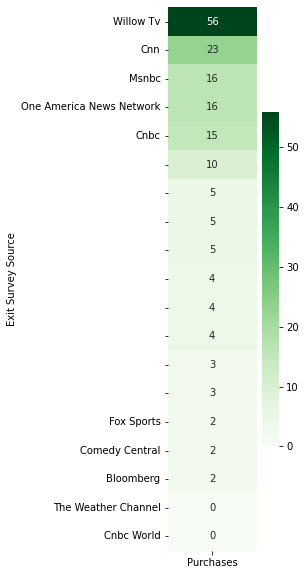

In [66]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
# sns.heatmap(num_purchases_sorted,annot=True, cmap='Greens', vmin=0, fmt='g')

sns.heatmap(num_purchases_sorted,
            #mask=mask3,
            annot=True, 
            cmap='Greens', 
            fmt='g',
            cbar=True,
            yticklabels=purchases_labels);


# sns.heatmap(num_purchases_sorted,
#             mask=~mask3,
#             annot=True, 
#             cmap='Greens', 
#             fmt='g',
#             annot_kws={"weight": "bold"},
#            cbar = False)
# sns.heatmap(num_purchases_sorted,
#             mask=mask3,
#             annot=True, 
#             cmap='Greens', 
#             fmt='g',
#             cbar=True,
#            yticklabels=purchases_labels);

# for label in ax.get_yticklabels()#.set_color('blue')
# ax.yaxis.set_tick_params(labelcolor='blue')
# sns.heatmap(num_purchases_sorted,
#             mask=(num_purchases_sorted<=num_purchases_sorted['Purchases'][4]) | (num_purchases_sorted>=num_purchases_sorted['Purchases'][-5]),
#             annot=True, 
#             cmap='Greens', 
#             fmt='g',
#             cbar=False)

In [67]:
spend_sorted = report_for_client[['Spend']].sort_values(by='Spend', ascending=False)

spend_labels = []
for count, label in enumerate(spend_sorted.index):
    #print(count, label)
    if count<5 or count>len(spend_sorted.index)-6:
        spend_labels.append(label)
    else:
        spend_labels.append('')

In [68]:
spend_labels

['Willow Tv',
 'Zeetv',
 'One America News Network',
 'Cnn',
 'Dateline',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Turner Network Tv',
 'Bloomberg',
 'Fox Sports',
 'Dish Network',
 'Cnbc World']

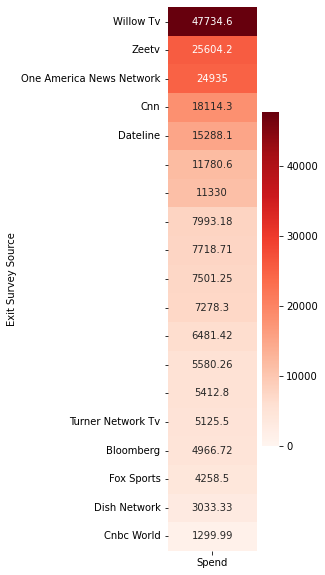

In [69]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Spend']].sort_values(by='Spend', ascending=False), annot=True, cmap='Reds', vmin=0, fmt='g', yticklabels=spend_labels);

In [70]:
lift_sorted = report_for_client[['Lift']].sort_values(by='Lift', ascending=False)

lift_labels = []
for count, label in enumerate(lift_sorted.index):
    #print(count, label)
    if count<5 or count>len(lift_sorted.index)-6:
        lift_labels.append(label)
    else:
        lift_labels.append('')

In [71]:
lift_labels

['Willow Tv',
 'One America News Network',
 'Star Plus',
 'Zeetv',
 'Msnbc',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Fox Sports',
 'Turner Network Tv',
 'Science',
 'Comedy Central',
 'Cnbc World']

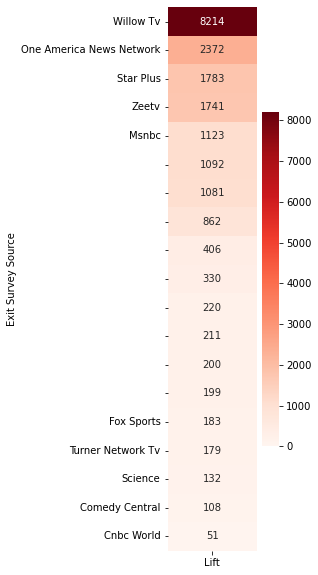

In [72]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Lift']].sort_values(by='Lift', ascending=False), annot=True, cmap='Reds', vmin=0, fmt='g', yticklabels=lift_labels);

In [73]:
mean_cost_per_visitor = report_for_client['Cost Per Visitor (Spend/Lift)'].mean()
mean_cost_per_visitor

23.388947368421054

In [74]:
cost_per_visitor_sorted = report_for_client[['Cost Per Visitor (Spend/Lift)']].sort_values(by='Cost Per Visitor (Spend/Lift)', ascending=True)

cost_per_visitor_labels = []
for count, label in enumerate(cost_per_visitor_sorted.index):
    #print(count, label)
    if count<5 or count>len(cost_per_visitor_sorted.index)-6:
        cost_per_visitor_labels.append(label)
    else:
        cost_per_visitor_labels.append('')

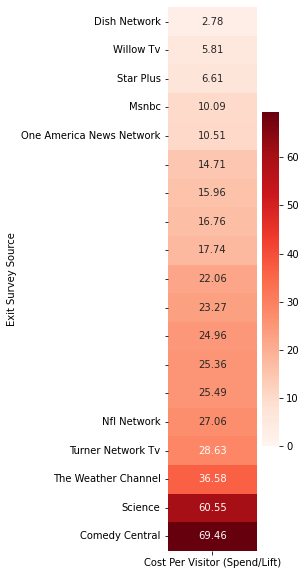

In [75]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Cost Per Visitor (Spend/Lift)']].sort_values(by='Cost Per Visitor (Spend/Lift)', ascending=True), annot=True, cmap='Reds', vmin=0, fmt='g', yticklabels=cost_per_visitor_labels);

In [76]:
mean_cpa = report_for_client[report_for_client['Purchases']>0]['Cost Per Acquisition (Spend/Purchases)'].mean()
mean_cpa

1841.3552941176472

In [77]:
cpa_sorted = report_for_client[['Cost Per Acquisition (Spend/Purchases)']].sort_values(by='Cost Per Acquisition (Spend/Purchases)', ascending=True)

cpa_labels = []
for count, label in enumerate(cpa_sorted.index):
    #print(count, label)
    if count<5 or count>len(cpa_sorted.index)-6:
        cpa_labels.append(label)
    else:
        cpa_labels.append('')

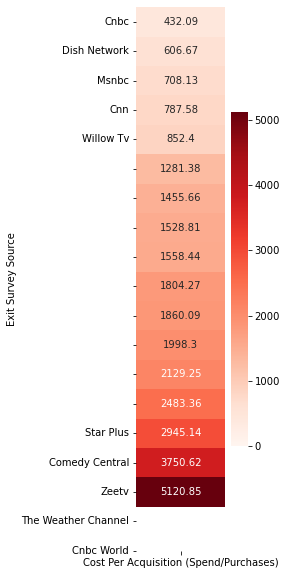

In [78]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
ax = sns.heatmap(report_for_client[['Cost Per Acquisition (Spend/Purchases)']].sort_values(by='Cost Per Acquisition (Spend/Purchases)', ascending=True)[:-2], annot=True, cmap='Reds', vmin=0, fmt='g', yticklabels=cpa_labels);

In [79]:
mean_conversion_rate = report_for_client['Conversion Rate (Purchases/Lift)%'].mean()
mean_conversion_rate

1.2842105263157892

In [80]:
conversion_rate_sorted = report_for_client[['Conversion Rate (Purchases/Lift)%']].sort_values(by='Conversion Rate (Purchases/Lift)%', ascending=False)

conversion_rate_labels = []
for count, label in enumerate(conversion_rate_sorted.index):
    #print(count, label)
    if count<5 or count>len(conversion_rate_sorted.index)-6:
        conversion_rate_labels.append(label)
    else:
        conversion_rate_labels.append('')

In [81]:
conversion_rate_labels

['Cnbc',
 'Science',
 'Turner Network Tv',
 'Cnn',
 'Comedy Central',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Dish Network',
 'Zeetv',
 'Star Plus',
 'The Weather Channel',
 'Cnbc World']

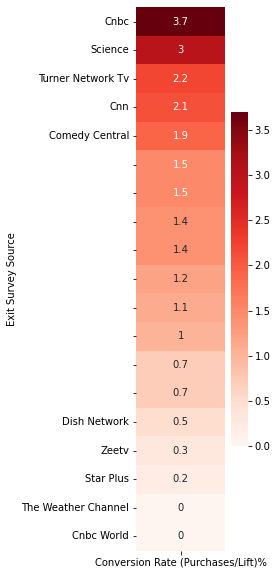

In [82]:
fig, ax = plt.subplots(1,1,figsize=(2,10))
sns.heatmap(report_for_client[['Conversion Rate (Purchases/Lift)%']].sort_values(by='Conversion Rate (Purchases/Lift)%', ascending=False), annot=True, cmap='Reds', vmin=0, fmt='g', yticklabels=conversion_rate_labels);

## Scatter Plots

### Plotting Function - make_scatter()

In [83]:
def make_scatter(df, x_field, y_field, x_units='', y_units='', color_1='green', color_2='red'):
    
    from adjustText import adjust_text
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # ax.tick_params(top=False,
    #                bottom=True,
    #                left=True,
    #                right=False,
    #                labelleft=False,
    #                labelbottom=False)
    
    df[x_field] = df[x_field].replace(np.inf, 0)
    df[y_field] = df[y_field].replace(np.inf, 0)
    
    df.plot(kind='scatter', x=x_field, y=y_field, ax=ax)
    
    x_field_mean = df[x_field].mean()
    y_field_mean = df[y_field].mean()
    
    if x_units == "$":
        x_field_mean = round(x_field_mean, 2)
    elif x_units == "%":
        x_field_mean = round(x_field_mean, 1)
    else:
        x_field_mean = round(x_field_mean)
        
    if y_units == "$":
        y_field_mean = round(y_field_mean, 2)
    elif y_units == "%":
        y_field_mean = round(y_field_mean, 1)
    else:
        y_field_mean = round(y_field_mean)

    
    low_x_high_y = df[(df[x_field] < x_field_mean) & (df[y_field] >= y_field_mean)]
    high_x_low_y = df[(df[x_field] >= x_field_mean) & (df[y_field] < y_field_mean)]

    together = []
    
    for i in range(len(low_x_high_y)):
        txt1 = low_x_high_y.index[i]
        x_coord1 = low_x_high_y[x_field][i]
        y_coord1 = low_x_high_y[y_field][i]
        #size1 = low_x_high_y['Purchases'][i]
        color1 = color_1
        together.append((txt1, x_coord1, y_coord1, color1))
        ax.scatter(x_coord1, y_coord1, color=color1)

    for i in range(len(high_x_low_y)):
        txt2 = high_x_low_y.index[i]
        x_coord2 = high_x_low_y[x_field][i]
        y_coord2 = high_x_low_y[y_field][i]
        color2 = color_2
        together.append((txt2, x_coord2, y_coord2, color2))
        ax.scatter(x_coord2, y_coord2, color=color2)
    together.sort()


    text = [x for (x,y,z,c) in together]
    x_coords = [y for (x,y,z,c) in together]
    y_coords = [z for (x,y,z,c) in together]
    colors = [c for (x,y,z,c) in together]

    texts = []
    for x, y, s, c in zip(x_coords, y_coords, text, colors):
        texts.append(plt.text(x, y, s, color=c))

    
    # I should lookup how to do this with regex to make things easier...
    x_annot_text = x_field
    y_annot_text = y_field
    if x_field == "Conversion Rate (Purchases/Lift)%":
        x_annot_text = "Conversion Rate"
    elif x_field == "Cost Per Acquisition (Spend/Purchases)":
        x_annot_text = "Cost Per Acquisition"
    elif x_field == "Cost Per Visitor (Spend/Lift)":
        x_annot_text = "Cost Per Visitor"
        
    if y_field == "Conversion Rate (Purchases/Lift)%":
        y_annot_text = "Conversion Rate"
    elif y_field == "Cost Per Acquisition (Spend/Purchases)":
        y_annot_text = "Cost Per Acquisition"
    elif y_field == "Cost Per Visitor (Spend/Lift)":
        y_annot_text = "Cost Per Visitor"
    
    
    
    plt.axvline(x=x_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean {x_annot_text}'#: {round(x_field_mean, 2)}{x_units}'
                ,
                xy=(x_field_mean, max(ax.get_ylim())), xycoords='data',
                xytext=(0, 2), textcoords='offset pixels',
                color='k', ha='center')
    
    plt.axhline(y=y_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean\n{y_annot_text}' #:\n{round(y_field_mean, 2)}{y_units}'
                ,
                xy=(max(ax.get_xlim()), y_field_mean), xycoords='data',
                xytext=(5, 0), textcoords='offset pixels',
                color='k', ha='left')
    
    ax.axes.set_xticks([0, x_field_mean])
    #ax.axes.xaxis.set_ticklabels([])
    ax.axes.set_yticks([0, y_field_mean])
    #ax.axes.yaxis.set_ticklabels([])
    adjust_text(texts, 
            force_text=(1,1),
            force_points=(1,1),
            force_objects=(1,1),
            only_move={'points':'y', 'texts':'y'},
            arrowprops=dict(arrowstyle="->", color='k', lw=0.5))

    plt.show();

In [224]:
def make_scatter2(df,
                  x_field,
                  y_field,
                  size_scale,
                  x_units='',
                  y_units='',
                  color_1='green',
                  color_2='red',
                  expand_text=(1.5, 1.5),
                  expand_points=(3,3),
                  expand_objects=(3,3),
                  force_text=(1,1),
                  force_points=(1,1),
                  force_objects=(1,1)):
    
    from adjustText import adjust_text
    
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # ax.tick_params(top=False,
    #                bottom=True,
    #                left=True,
    #                right=False,
    #                labelleft=False,
    #                labelbottom=False)
    
    df[x_field] = df[x_field].replace(np.inf, 0)
    df[y_field] = df[y_field].replace(np.inf, 0)
    
    df.plot(kind='scatter', x=x_field, y=y_field, ax=ax)
    
    x_field_mean = df[x_field].mean()
    y_field_mean = df[y_field].mean()
    
    if x_units == "$":
        x_field_mean = round(x_field_mean, 2)
    elif x_units == "%":
        x_field_mean = round(x_field_mean, 1)
    else:
        x_field_mean = round(x_field_mean)
        
    if y_units == "$":
        y_field_mean = round(y_field_mean, 2)
    elif y_units == "%":
        y_field_mean = round(y_field_mean, 1)
    else:
        y_field_mean = round(y_field_mean)

    
    low_x_high_y = df[(df[x_field] < x_field_mean) & (df[y_field] >= y_field_mean)]
    high_x_low_y = df[(df[x_field] >= x_field_mean) & (df[y_field] < y_field_mean)]

    together = []
    
    for i in range(len(low_x_high_y)):
        txt1 = low_x_high_y.index[i]
        x_coord1 = low_x_high_y[x_field][i]
        y_coord1 = low_x_high_y[y_field][i]
        size1 = low_x_high_y['Purchases'][i]
        if size1 == 0:
            size1 = size_scale * 1 / size_scale
        color1 = color_1
        together.append((txt1, x_coord1, y_coord1, color1))
        ax.scatter(x_coord1, y_coord1, color=color1, s=size1*size_scale)

    for i in range(len(high_x_low_y)):
        txt2 = high_x_low_y.index[i]
        x_coord2 = high_x_low_y[x_field][i]
        y_coord2 = high_x_low_y[y_field][i]
        size2 = high_x_low_y['Purchases'][i]
        if size2 == 0:
            size2 = size_scale * 1 / size_scale
        color2 = color_2
        together.append((txt2, x_coord2, y_coord2, color2))
        ax.scatter(x_coord2, y_coord2, color=color2, s=size2*size_scale)
    together.sort()


    text = [x for (x,y,z,c) in together]
    x_coords = [y for (x,y,z,c) in together]
    y_coords = [z for (x,y,z,c) in together]
    colors = [c for (x,y,z,c) in together]

    texts = []
    for x, y, s, c in zip(x_coords, y_coords, text, colors):
        texts.append(plt.text(x, y, s, color=c))

    
    # I should lookup how to do this with regex to make things easier...
    x_annot_text = x_field
    y_annot_text = y_field
    if x_field == "Conversion Rate (Purchases/Lift)%":
        x_annot_text = "Conversion Rate"
    elif x_field == "Cost Per Acquisition (Spend/Purchases)":
        x_annot_text = "Cost Per Acquisition"
    elif x_field == "Cost Per Visitor (Spend/Lift)":
        x_annot_text = "Cost Per Visitor"
        
    if y_field == "Conversion Rate (Purchases/Lift)%":
        y_annot_text = "Conversion Rate"
    elif y_field == "Cost Per Acquisition (Spend/Purchases)":
        y_annot_text = "Cost Per Acquisition"
    elif y_field == "Cost Per Visitor (Spend/Lift)":
        y_annot_text = "Cost Per Visitor"
    
    
    
    plt.axvline(x=x_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean {x_annot_text}'#: {round(x_field_mean, 2)}{x_units}'
                ,
                xy=(x_field_mean, max(ax.get_ylim())), xycoords='data',
                xytext=(0, 2), textcoords='offset pixels',
                color='k', ha='center')
    
    plt.axhline(y=y_field_mean, linestyle=(0, (2, 8)), color='k')
    ax.annotate(F'Mean\n{y_annot_text}' #:\n{round(y_field_mean, 2)}{y_units}'
                ,
                xy=(max(ax.get_xlim()), y_field_mean), xycoords='data',
                xytext=(5, 0), textcoords='offset pixels',
                color='k', ha='left')
    
    ax.axes.set_xticks([0, x_field_mean])
    #ax.axes.xaxis.set_ticklabels([])
    ax.axes.set_yticks([0, y_field_mean])
    #ax.axes.yaxis.set_ticklabels([])
    adjust_text(texts,
            expand_text=expand_text,
            expand_points=expand_points,
            expand_objects=expand_objects,
            force_text=force_text,
            force_points=force_points,
            force_objects=force_objects,
            only_move={'points':'y', 'texts':'y'},
            arrowprops=dict(arrowstyle="->", color='k', lw=0.5))

    plt.show();

In [225]:
scale=10

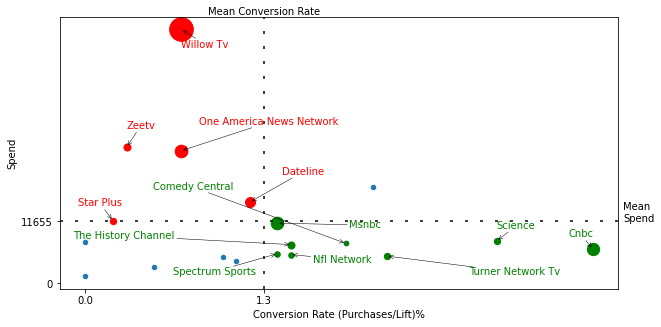

In [226]:
make_scatter2(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Spend',
             size_scale=scale,
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

#### Purchases vs. Spend

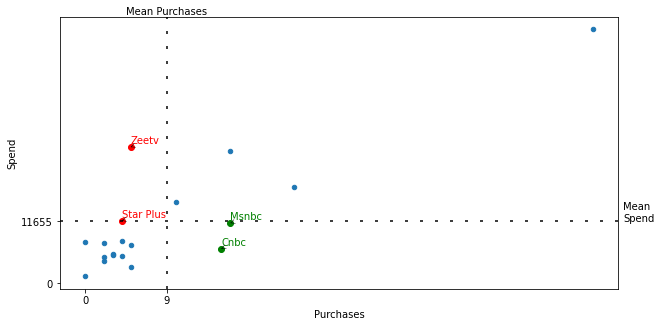

In [174]:
make_scatter(df=report_for_client,
             x_field='Purchases',
             y_field='Spend',
             #size=False,
             x_units='',
             y_units='$',
             color_1='red',
             color_2='green')

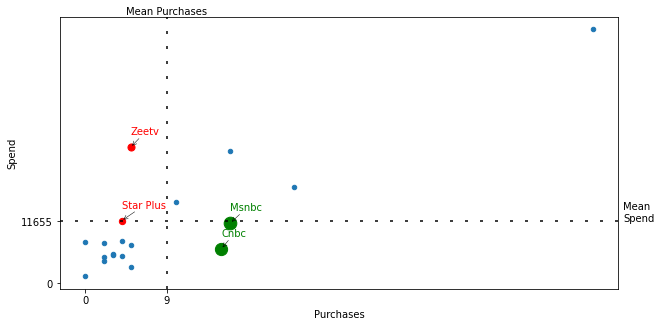

In [214]:
make_scatter2(df=report_for_client,
             x_field='Purchases',
             y_field='Spend',
             size_scale=scale,
             x_units='',
             y_units='$',
             color_1='red',
             color_2='green')

#### Lift vs. Spend

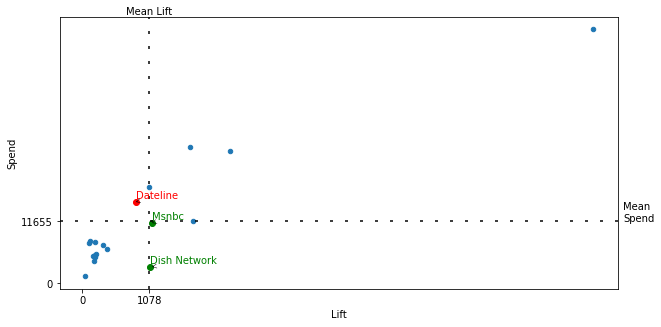

In [176]:
make_scatter(report_for_client,
             x_field='Lift',
             y_field='Spend',
             #size=True,
             x_units='',
             y_units='$',
             color_1='red',
             color_2='green')

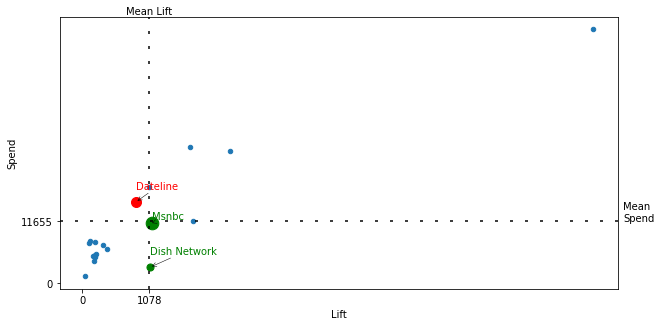

In [215]:
make_scatter2(report_for_client,
             x_field='Lift',
             y_field='Spend',
             size_scale=scale,
             x_units='',
             y_units='$',
             color_1='red',
             color_2='green')

#### Lift vs. Purchases

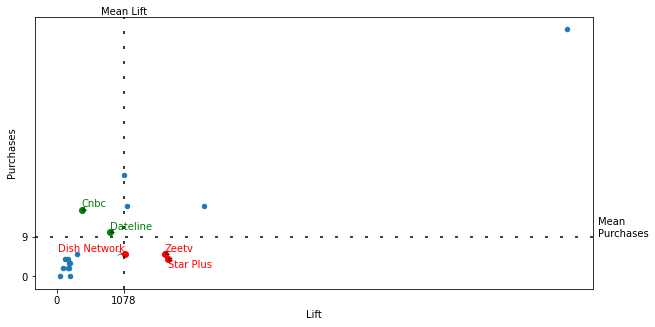

In [178]:
make_scatter(report_for_client,
             x_field='Lift',
             y_field='Purchases',
             x_units='',
             y_units='')

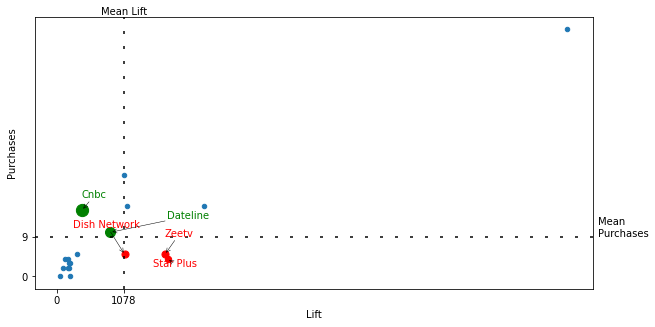

In [216]:
make_scatter2(report_for_client,
             x_field='Lift',
             y_field='Purchases',
             size_scale=scale,
             x_units='',
             y_units='')

#### Conversion Rate vs. Spend

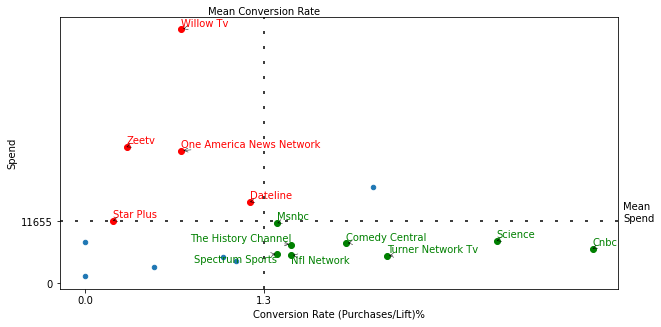

In [180]:
make_scatter(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Spend',
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

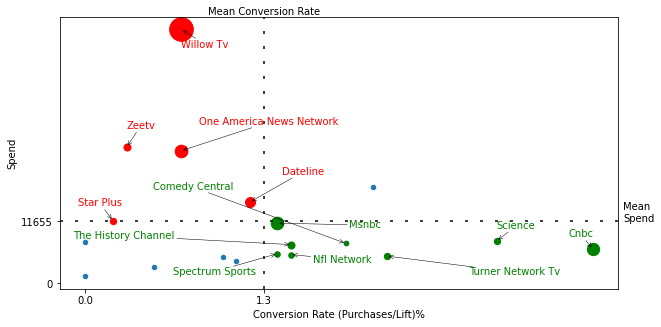

In [222]:
make_scatter2(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Spend',
             size_scale=scale,
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

#### Conversion Rate vs. Cost Per Acquisition

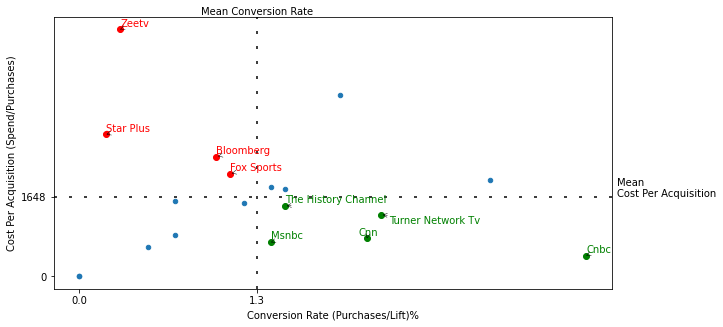

In [90]:
make_scatter(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Cost Per Acquisition (Spend/Purchases)',
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

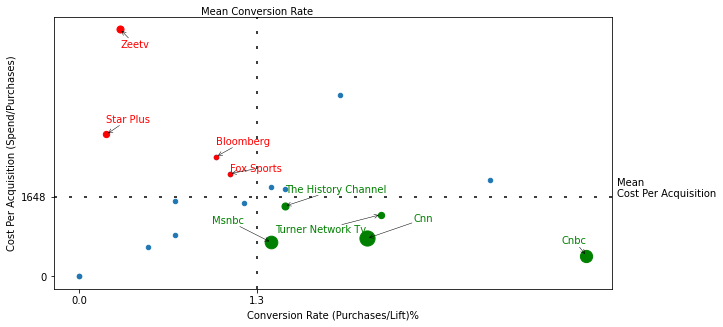

In [218]:
make_scatter2(report_for_client,
             x_field='Conversion Rate (Purchases/Lift)%',
             y_field='Cost Per Acquisition (Spend/Purchases)',
             size_scale=scale,
             x_units='%',
             y_units='$',
             color_1='red',
             color_2='green')

#### Conversion Rate vs. Cost Per Visitor

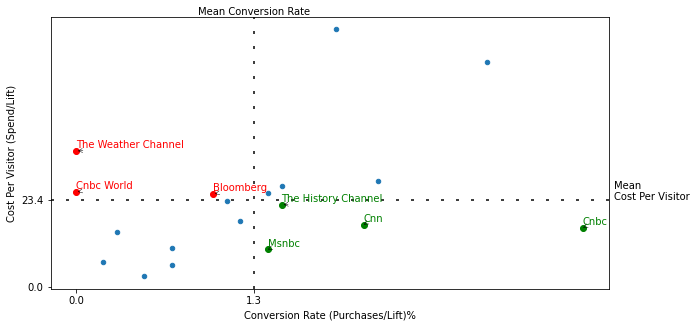

In [91]:
make_scatter(df=report_for_client,
             x_field="Conversion Rate (Purchases/Lift)%",
             y_field="Cost Per Visitor (Spend/Lift)",
             x_units="%",
             y_units="$",
             color_1='red',
             color_2='green')

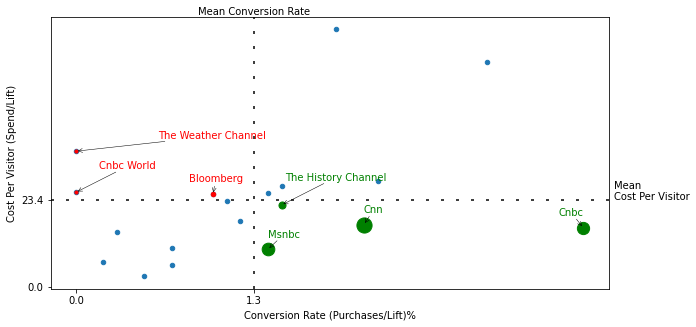

In [221]:
make_scatter2(df=report_for_client,
             x_field="Conversion Rate (Purchases/Lift)%",
             y_field="Cost Per Visitor (Spend/Lift)",
             size_scale=scale,
             x_units="%",
             y_units="$",
             color_1='red',
             color_2='green')

## Which Networks have no spend but we see purchases?

In [92]:
no_spend_but_purchases = purchases_spend_lift_by_network.query("Spend == 0 & Purchases > 0 & `Exit Survey` != 'Other' & `Exit Survey` != '(Blank)'")
no_spend_but_purchases

,Purchases,Spend,Lift,Conversion Rate (Purchases/Lift)%,Cost Per Acquisition (Spend/Purchases),Cost Per Visitor (Spend/Lift),Percent of Purchases,Percent of Spend,Percent Pur > Percent Spend
Exit Survey,,,,,,,,,
Aapka Colors,6.0,0.0,0.0,inf,0.0,NaN,2.542373,0.0,True
Baby First,1.0,0.0,0.0,inf,0.0,NaN,0.423729,0.0,True
Cbs Sports,1.0,0.0,0.0,inf,0.0,NaN,0.423729,0.0,True
Diy,2.0,0.0,0.0,inf,0.0,NaN,0.847458,0.0,True
Espn,4.0,0.0,0.0,inf,0.0,NaN,1.694915,0.0,True
Fox News,14.0,0.0,0.0,inf,0.0,NaN,5.932203,0.0,True
Fyi,2.0,0.0,0.0,inf,0.0,NaN,0.847458,0.0,True
Hgtv,6.0,0.0,0.0,inf,0.0,NaN,2.542373,0.0,True
Oprah Winfrey Network,1.0,0.0,0.0,inf,0.0,NaN,0.423729,0.0,True


In [93]:
no_spend_but_purchases = purchases_spend_lift_by_network.query("Spend == 0 & Purchases > 0 & `Exit Survey` != 'Other' & `Exit Survey` != '(Blank)'")

no_spend_but_purchases = no_spend_but_purchases.sort_values('Purchases', ascending=False)[['Purchases']]

In [94]:
no_spend_but_purchases

,Purchases
Exit Survey,
Fox News,14.0
Aapka Colors,6.0
Hgtv,6.0
Espn,4.0
Sony Entertainment Tv,4.0
Television Food Network,4.0
Diy,2.0
Fyi,2.0
Baby First,1.0


In [95]:
no_spend_but_purchases['percent_of_all_purchases'] = no_spend_but_purchases['Purchases'] / total_purchases_from_campaign * 100

In [96]:
no_spend_but_purchases

,Purchases,percent_of_all_purchases
Exit Survey,,
Fox News,14.0,5.932203
Aapka Colors,6.0,2.542373
Hgtv,6.0,2.542373
Espn,4.0,1.694915
Sony Entertainment Tv,4.0,1.694915
Television Food Network,4.0,1.694915
Diy,2.0,0.847458
Fyi,2.0,0.847458
Baby First,1.0,0.423729


In [97]:
mean_num_purchases_with_spend = report_for_client['Purchases'].mean()
mean_num_purchases_from_campaign = purchases_spend_lift_by_network['Purchases'].mean()

In [98]:
import matplotlib.patheffects as pe

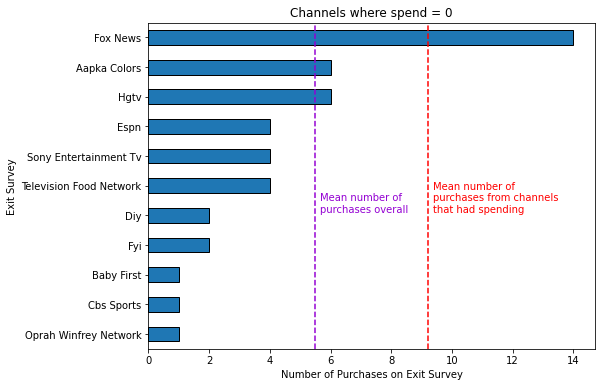

In [99]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
no_spend_but_purchases['Purchases'].plot(kind='barh', ax=ax, edgecolor='black')
ax.set_xlabel('Number of Purchases on Exit Survey')
ax.set_title('Channels where spend = 0')


ax.axvline(mean_num_purchases_with_spend, color='red', linestyle='--')
text1 = ax.annotate(F'Mean number of\npurchases from channels\nthat had spending',
                xy=(mean_num_purchases_with_spend, 0), xycoords='data',
                xytext=(5, -175), textcoords='offset pixels',
                color='red', ha='left')
# text1.set_path_effects(path_effects=[pe.withStroke(linewidth=0.5, foreground='black'), pe.Normal()])

ax.axvline(mean_num_purchases_from_campaign, color='darkviolet', linestyle='--')
text2 = ax.annotate(F'Mean number of\npurchases overall',
                xy=(mean_num_purchases_from_campaign, 0), xycoords='data',
                xytext=(5, -175), textcoords='offset pixels',
                color='darkviolet', ha='left')
# text2.set_path_effects(path_effects=[pe.withStroke(linewidth=0.5, foreground='black'), pe.Normal()])

ax.invert_yaxis();

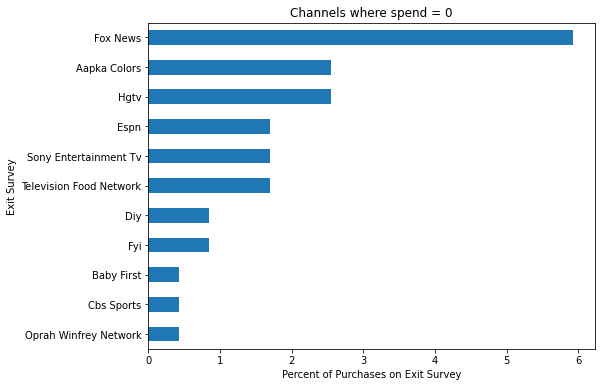

In [100]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
no_spend_but_purchases['percent_of_all_purchases'].plot(kind='barh', ax=ax)
ax.set_xlabel('Percent of Purchases on Exit Survey')
ax.set_title('Channels where spend = 0')
ax.invert_yaxis();

In [101]:
num_purchases_no_spend = report_for_client[report_for_client['Spend']==0].groupby("Exit Survey Source")['Purchases'].agg('sum')

tot_purchases_no_spend = sum(num_purchases_no_spend)

perc_purchases_no_spend = num_purchases_no_spend / tot_purchases_no_spend * 100
perc_purchases_no_spend = perc_purchases_no_spend.sort_values(ascending=False)

perc_purchases_no_spend
# (report_for_client[report_for_client['Spend']==0].groupby("Exit Survey Source")['Purchases'].agg('sum') / sum(report_for_client[report_for_client['Spend']==0].groupby("Exit Survey Source")['Purchases'].agg('sum')) * 100).sort_values(ascending=False)

Series([], Name: Purchases, dtype: float64)

# Graphing

## Bar Charts

In [102]:
# ax = report_purchases_sorted[0:10].plot(kind='barh', y='Purchases', title='Top 10 Networks by Purchase', legend=False)
# ax.invert_yaxis()
# ax.set_xlabel('Number of Purchases');

In [103]:
# ax = report_purchases_sorted[-10:].plot(kind='barh', y='Purchases', title='Bottom 10 Networks by Purchase', legend=False)
# ax.invert_yaxis()
# ax.set_xlabel('Number of Purchases')
# ax.set_xticks(np.arange(0,3,1));

In [104]:
# ax = report_purchases_sorted[0:10].plot(kind='barh', y='Purchases', title='Top 10 Networks by Purchase', legend=False, color='blue')
# ax.invert_yaxis()
# ax.set_xlabel('Number of Purchases')
# ax1 = ax.twiny()
# report_purchases_sorted[0:10].plot(kind='barh', y='Spend', title='Top 10 Networks by Purchase', legend=False, ax=ax, color='r');

In [105]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.set_xlabel('Number of Purchases')


# ax2 = ax.twiny()
# ax2.set_xlabel('Amount Spent ($)')


# bar1 = report_purchases_sorted['Purchases'][0:10].plot(kind='barh', color='green', position=1, width=0.4, ax=ax, label='Purchases')
# bar2 = report_purchases_sorted['Spend'][0:10].plot(kind='barh', color='red', position=0, width=0.4, ax=ax2, label='Spend')

# #ax2.invert_yaxis()
# plt.ylim((-0.5, len(report_purchases_sorted[0:10])-0.5))
# ax.invert_yaxis()

# bars, labels = ax.get_legend_handles_labels()
# bars2, labels2 = ax2.get_legend_handles_labels()
# ax.legend(bars+bars2, labels+labels2, loc='lower right')

# ;

In [106]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(111)
# ax.set_xlabel('Number of Purchases')


# ax2 = ax.twiny()
# ax2.set_xlabel('Amount Spent ($)')


# report_purchases_sorted['Purchases'][-10:].plot(kind='barh', color='blue', position=1, width=0.4, ax=ax)
# report_purchases_sorted['Spend'][-10:].plot(kind='barh', color='red', position=0, width=0.4, ax=ax2)
# ax.invert_yaxis()
# #ax2.invert_yaxis()
# plt.ylim((-0.5, len(report_purchases_sorted[0:10])-0.5));

### Manual Plots

In [107]:
#Q1: High Purchases, High Spend, check cost per acquisition?
#Q2: Low Purchases, High Spend, Bad!
low_purchase_high_spend = report_for_client.query(F'(Purchases < {mean_purchases}) & (Spend >= {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)
#Q3: Low Purchases, Low Spend, check cost per acquisition?
#Q4: High Purchases, Low Spend, great!
high_purchase_low_spend = report_for_client.query(F'(Purchases >= {mean_purchases}) & (Spend < {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client[['Purchases', 'Spend']].plot(kind='scatter', x='Purchases', y='Spend', ax=ax)

plt.tick_params(left=True,labelleft=False,
                   labelbottom=False)

for i in range(len(low_purchase_high_spend)):
    txt = low_purchase_high_spend.index[i]
    x_coord = low_purchase_high_spend['Purchases'][i]
    y_coord = low_purchase_high_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1_000), color='red', ha='center')
    ax.scatter(x_coord, y_coord, color='red')
    
for i in range(len(high_purchase_low_spend)):
    txt = high_purchase_low_spend.index[i]
    x_coord = high_purchase_low_spend['Purchases'][i]
    y_coord = high_purchase_low_spend['Spend'][i]
    ax.scatter(x_coord, y_coord, color='green')
    if i == 3:
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord-0.5, y_coord+1_000), color='green', ha='right')
    elif i == 2:
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+0.5, y_coord+1_000), color='green', ha='left')
    else:
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+0.5, y_coord+1_000), color='green', ha='center')

#report_top_5_purchases[['Purchases', 'Spend']].plot(kind='scatter', x='Purchases', y='Spend', color='red', ax=ax)
plt.axhline(y=mean_spend, linestyle='--', color='k')
plt.text(x=45, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend,2)}', color='k')
plt.axvline(x=mean_purchases, linestyle='--', color='k')
plt.text(x=mean_purchases+0.5, y=48_000, s=F'Mean Purchases: {round(mean_purchases)}', color='k')

# plt.text(x=2, y=45_000, s='Low Purchases,', ha='center', color='red')
# plt.text(x=2, y=43_000, s='High Spend', ha='center', color='red')

# plt.text(x=40, y=5_000, s='High Purchases,', ha='center', color='green')
# plt.text(x=40, y=3_000, s='Low Spend', ha='center', color='green')

plt.show();

NameError: name 'mean_purchases' is not defined

In [ ]:
report_for_client.query(F'(Purchases >= {mean_purchases}) & (Spend >= {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
report_for_client.query(F'(Purchases < {mean_purchases}) & (Spend >= {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
report_for_client.query(F'(Purchases < {mean_purchases}) & (Spend < {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
report_for_client.query(F'(Purchases >= {mean_purchases}) & (Spend < {mean_spend})').sort_values('Cost Per Acquisition (Spend/Purchases)', ascending=False)

In [ ]:
#Q1: High Lift, High Spend, check cost per visitor?
#Q2: Low Lift, High Spend, Bad!
#Q3: Low Lift, Low Spend, check cost per visitor?
#Q4: High Lift, Low Spend great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Lift', y='Spend', ax=ax)
#report_top_5_purchases.plot(kind='scatter', x='Lift', y='Spend', color='red', ax=ax)

low_lift_high_spend = report_for_client.query(F'(Lift < {mean_lift}) & (Spend >= {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(low_lift_high_spend)):
    txt = low_lift_high_spend.index[i]
    x_coord = low_lift_high_spend['Lift'][i]
    y_coord = low_lift_high_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1_000), color='red', ha='right')
    ax.scatter(x_coord, y_coord, color='red')

high_lift_low_spend = report_for_client.query(F'(Lift >= {mean_lift}) & (Spend < {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(high_lift_low_spend)):
    txt = high_lift_low_spend.index[i]
    x_coord = high_lift_low_spend['Lift'][i]
    y_coord = high_lift_low_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+50, y_coord-2_000), color='green', ha='left')
    ax.scatter(x_coord, y_coord, color='green')

# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_lift)

plt.axhline(y=mean_spend, linestyle='--', color='k')
plt.text(x=6_500, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend,2)}', color='k')

plt.axvline(x=mean_lift, linestyle='--', color='k')
plt.text(x=mean_lift+100, y=48_000, s=F'Mean Lift: {round(mean_lift)}', color='k')

plt.show();

In [ ]:
report_for_client.query(F'(Lift >= {mean_lift}) & (Spend >= {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift < {mean_lift}) & (Spend >= {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift < {mean_lift}) & (Spend < {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift >= {mean_lift}) & (Spend < {mean_spend})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
#Q1: High Lift, High Purchases, check _?
#Q2: Low Lift, High Purchases, check spend, maybe spend more here!
#Q3: Low Lift, Low Purchases, check conversion rate, spend more on ones that have high conversion rate?  Maybe also check cost per visitor?
#Q4: High Lift, Low Purchases, not good?
fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Lift', y='Purchases', ax=ax)

low_lift_high_purchases = report_for_client.query(F'(Lift < {mean_lift}) & (Purchases >= {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(low_lift_high_purchases)):
    txt = low_lift_high_purchases.index[i]
    x_coord = low_lift_high_purchases['Lift'][i]
    y_coord = low_lift_high_purchases['Purchases'][i]
    if i == 1: #cnbc
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+2), color='green', ha='left')
        ax.scatter(x_coord, y_coord, color='green')
    elif i == 2: #fox news
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1), color='green', ha='center')
        ax.scatter(x_coord, y_coord, color='green')
    elif i == 3: #other
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord-3), color='green', ha='center')
        ax.scatter(x_coord, y_coord, color='green')
    else: #cnbc and dateline
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1), color='green', ha='center')
        ax.scatter(x_coord, y_coord, color='green')

high_lift_low_purchases = report_for_client.query(F'(Lift >= {mean_lift}) & (Purchases < {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

for i in range(len(high_lift_low_purchases)):
    txt = high_lift_low_purchases.index[i]
    x_coord = high_lift_low_purchases['Lift'][i]
    y_coord = high_lift_low_purchases['Purchases'][i]
    
    if i == 2: #dishnetwork
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+140, y_coord-5), color='red', ha='center')
        ax.scatter(x_coord, y_coord, color='red')
    elif i == 0: #zeetv
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1), color='red', ha='center')
        ax.scatter(x_coord, y_coord, color='red')
    else: #starplus
        ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord+100, y_coord-2), color='red', ha='left')
        ax.scatter(x_coord, y_coord, color='red')

# report_top_5_purchases.plot(kind='scatter', x='Lift', y='Purchases', color='red', ax=ax)
# plt.axhline(y=mean_purchases)
# plt.axvline(x=mean_lift)

plt.axhline(y=mean_purchases, linestyle='--', color='k')
plt.text(x=6_500, y=mean_purchases+1, s=F'Mean Purchases: {round(mean_purchases)}', color='k')

plt.axvline(x=mean_lift, linestyle='--', color='k')
plt.text(x=mean_lift+100, y=55, s=F'Mean Lift: {round(mean_lift)}', color='k')

plt.show();

In [ ]:
report_for_client.query(F'(Lift < {mean_lift}) & (Purchases >= {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
report_for_client.query(F'(Lift >= {mean_lift}) & (Purchases < {mean_purchases})').sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
#Q1: High Conversion Rate, High Spend, check _?
#Q2: Low Conversion Rate, High Spend, bad!
#Q3: Low Conversion Rate, Low Spend, check conversion rate, check cost per acquisition and cost per visitor?
#Q4: high Conversion Rate, Low Spend great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', ax=ax)

low_conversion_rate_high_spend = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Spend"] >= mean_spend)]

for i in range(len(low_conversion_rate_high_spend)):
    txt = low_conversion_rate_high_spend.index[i]
    x_coord = low_conversion_rate_high_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord = low_conversion_rate_high_spend['Spend'][i]
    ax.annotate(txt, xy=(x_coord, y_coord), xytext=(x_coord, y_coord+1_000), color='red', ha='center')
    ax.scatter(x_coord, y_coord, color='red')

    
high_conversion_rate_low_spend = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Spend"] < mean_spend)]
    
# report_top_5_purchases.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', color='red', ax=ax)
# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_conversion_rate)

plt.axhline(y=mean_spend, linestyle='--', color='k')
plt.text(x=3, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle='--', color='k')
plt.text(x=mean_conversion_rate+0.05, y=45_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show();

#### Where you started using adjustText

In [ ]:
from adjustText import adjust_text

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', ax=ax)

together1 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(low_conversion_rate_high_spend)):
    txt1 = low_conversion_rate_high_spend.index[i]
    x_coord1 = low_conversion_rate_high_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_spend['Spend'][i]
    together1.append((txt1, x_coord1, y_coord1))
    ax.scatter(x_coord1, y_coord1, color='red')
together1.sort()

text1 = [x for (x,y,z) in together1]
x_coords1 = [y for (x,y,z) in together1]
y_coords1 = [z for (x,y,z) in together1]

texts1 = []
for x, y, s in zip(x_coords1, y_coords1, text1):
    texts1.append(plt.text(x, y, s, color='red'))

adjust_text(texts1, only_move={'points':'y', 'texts1':'y'})


together2 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(high_conversion_rate_low_spend)):
    txt2 = high_conversion_rate_low_spend.index[i]
    x_coord2 = high_conversion_rate_low_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_spend['Spend'][i]
    together2.append((txt2, x_coord2, y_coord2))
    ax.scatter(x_coord2, y_coord2, color='green')
together2.sort()

text2 = [x for (x,y,z) in together2]
x_coords2 = [y for (x,y,z) in together2]
y_coords2 = [z for (x,y,z) in together2]

texts2 = []
for x, y, s in zip(x_coords2, y_coords2, text2):
    texts2.append(plt.text(x, y, s, color='green'))

adjust_text(texts2, only_move={'points':'y', 'texts2':'y'})

plt.axhline(y=mean_spend, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.9, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=45_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show()

In [ ]:
from adjustText import adjust_text

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Spend', ax=ax)

together = []

for i in range(len(low_conversion_rate_high_spend)):
    txt1 = low_conversion_rate_high_spend.index[i]
    x_coord1 = low_conversion_rate_high_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_spend['Spend'][i]
    color1 = 'red'
    together.append((txt1, x_coord1, y_coord1, color1))
    ax.scatter(x_coord1, y_coord1, color=color1)

for i in range(len(high_conversion_rate_low_spend)):
    txt2 = high_conversion_rate_low_spend.index[i]
    x_coord2 = high_conversion_rate_low_spend['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_spend['Spend'][i]
    color2 = 'green'
    together.append((txt2, x_coord2, y_coord2, color2))
    ax.scatter(x_coord2, y_coord2, color=color2)
together.sort()

text = [x for (x,y,z,c) in together]
x_coords = [y for (x,y,z,c) in together]
y_coords = [z for (x,y,z,c) in together]
colors = [c for (x,y,z,c) in together]

texts = []
for x, y, s, c in zip(x_coords, y_coords, text, colors):
    texts.append(plt.text(x, y, s, color=c))

adjust_text(texts, only_move={'points':'y', 'texts':'y'})


plt.axhline(y=mean_spend, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.9, y=mean_spend+1_000, s=F'Mean Spend: ${round(mean_spend, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=45_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show()

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Spend"] >= mean_spend)]

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Spend"] < mean_spend)]

In [ ]:
# report_for_client.query("(Conversion Rate (Purchases/Lift)% < {0}) & (Spend >= {1})".format(mean_conversion_rate, mean_spend)).sort_values('Cost Per Visitor (Spend/Lift)', ascending=False)

In [ ]:
# # This chart just seems bad

# #Q1: High Cost Per Acquisition, High Spend, bad!
# #Q2: Low Cost Per Acquisition, High Spend, must mean lots of purchases?  Doesn't make a lot of sense
# #Q3: Low Cost Per Acquisition, Low Spend, check conversion rate, check cost per acquisition and cost per visitor?
# #Q4: Low Spend, high Cost Per Acquisition, doesn't make a lot of sense..?
# fig, ax = plt.subplots(1,1,figsize=(10,5))
# report_for_client.plot(kind='scatter', x='Cost Per Acquisition', y='Spend', ax=ax)
# report_top_5_purchases.plot(kind='scatter', x='Cost Per Acquisition', y='Spend', color='red', ax=ax)
# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_cpa)
# ;

In [ ]:
# # This chart just seems bad

# #Q1: High Cost Per Visitor, High Spend, none present, doesn't matter
# #Q2: Low Cost Per Visitor, High Spend, Seems weird? Doesn't make sense
# #Q3: Low Cost Per Visitor, Low Spend, Seems weird, doesn't make sense
# #Q4: High Cost Per Visitor, Low Spend, seems weird, doesn't make sense

# fig, ax = plt.subplots(1,1,figsize=(10,5))
# report_for_client.plot(kind='scatter', x='Cost Per Visitor', y='Spend', ax=ax)
# report_top_5_purchases.plot(kind='scatter', x='Cost Per Visitor', y='Spend', color='red', ax=ax)
# plt.axhline(y=mean_spend)
# plt.axvline(x=mean_cost_per_visitor)
# ;

In [ ]:
#Q1: High Conversion Rate, High Cost Per Acquisition, check _?
#Q2: Low Conversion Rate, High Cost Per Acquisition, bad!
#Q3: Low Conversion Rate, Low Cost Per Acquisition, unsure?
#Q4: High Conversion Rate, Low Cost Per Acquisition, great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Acquisition (Spend/Purchases)', ax=ax)


report_top_5_purchases.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Acquisition (Spend/Purchases)', color='red', ax=ax)
plt.axhline(y=mean_cpa)
plt.axvline(x=mean_conversion_rate)

plt.show();

In [ ]:
make_scatter(df=report_for_client,
             x_field="Conversion Rate (Purchases/Lift)%",
             y_field="Cost Per Acquisition (Spend/Purchases)",
             x_units="%",
             y_units="$")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Acquisition (Spend/Purchases)', ax=ax)

low_conversion_rate_high_cost_per_acquisition = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] >= mean_cpa)]

together = []

for i in range(len(low_conversion_rate_high_cost_per_acquisition)):
    txt1 = low_conversion_rate_high_cost_per_acquisition.index[i]
    x_coord1 = low_conversion_rate_high_cost_per_acquisition['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_cost_per_acquisition['Cost Per Acquisition (Spend/Purchases)'][i]
    color1 = 'red'
    together.append((txt1, x_coord1, y_coord1, color1))
    ax.scatter(x_coord1, y_coord1, color=color1)


high_conversion_rate_low_cost_per_acquisition = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] < mean_cpa)]


for i in range(len(high_conversion_rate_low_cost_per_acquisition)):
    txt2 = high_conversion_rate_low_cost_per_acquisition.index[i]
    x_coord2 = high_conversion_rate_low_cost_per_acquisition['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_cost_per_acquisition['Cost Per Acquisition (Spend/Purchases)'][i]
    color2 = 'green'
    together.append((txt2, x_coord2, y_coord2, color2))
    ax.scatter(x_coord2, y_coord2, color=color2)
together.sort()

    
text = [x for (x,y,z,c) in together]
x_coords = [y for (x,y,z,c) in together]
y_coords = [z for (x,y,z,c) in together]
colors = [c for (x,y,z,c) in together]

texts = []
for x, y, s, c in zip(x_coords, y_coords, text, colors):
    texts.append(plt.text(x, y, s, color=c))

adjust_text(texts, only_move={'points':'y', 'texts':'y'})


plt.axhline(y=mean_cpa, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.5, y=mean_cpa-300, s=F'Mean Cost Per Acquisition: ${round(mean_cpa, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=5_000, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show();

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] >= mean_cpa)]

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Acquisition (Spend/Purchases)"] < mean_cpa)]

In [ ]:
#Q1: High Conversion Rate, High Cost Per Visitor, check _?
#Q2: Low Conversion Rate, High Cost Per Visitor, bad!
#Q3: Low Conversion Rate, Low Cost Per Visitor, unsure?
#Q4: High Conversion Rate, Low Cost Per Visitor, great!

fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Visitor (Spend/Lift)', ax=ax)
report_top_5_purchases.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Visitor (Spend/Lift)', color='red', ax=ax)
plt.axhline(y=mean_cost_per_visitor)
plt.axvline(x=mean_conversion_rate)
;

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
report_for_client.plot(kind='scatter', x='Conversion Rate (Purchases/Lift)%', y='Cost Per Visitor (Spend/Lift)', ax=ax)

low_conversion_rate_high_cost_per_visitor = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] >= mean_cost_per_visitor)]

together1 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(low_conversion_rate_high_cost_per_visitor)):
    txt1 = low_conversion_rate_high_cost_per_visitor.index[i]
    x_coord1 = low_conversion_rate_high_cost_per_visitor['Conversion Rate (Purchases/Lift)%'][i]
    y_coord1 = low_conversion_rate_high_cost_per_visitor['Cost Per Visitor (Spend/Lift)'][i]
    together1.append((txt1, x_coord1, y_coord1))
    ax.scatter(x_coord1, y_coord1, color='red')
together1.sort()

text1 = [x for (x,y,z) in together1]
x_coords1 = [y for (x,y,z) in together1]
y_coords1 = [z for (x,y,z) in together1]

texts1 = []
for x, y, s in zip(x_coords1, y_coords1, text1):
    texts1.append(plt.text(x, y, s, color='red'))

adjust_text(texts1, only_move={'points':'y', 'texts1':'y'})

high_conversion_rate_low_cost_per_visitor = report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] < mean_cost_per_visitor)]

together2 = []
# text_list = []
# x_coords = []
# y_coords = []
for i in range(len(high_conversion_rate_low_cost_per_visitor)):
    txt2 = high_conversion_rate_low_cost_per_visitor.index[i]
    x_coord2 = high_conversion_rate_low_cost_per_visitor['Conversion Rate (Purchases/Lift)%'][i]
    y_coord2 = high_conversion_rate_low_cost_per_visitor['Cost Per Visitor (Spend/Lift)'][i]
    together2.append((txt2, x_coord2, y_coord2))
    ax.scatter(x_coord2, y_coord2, color='green')
together2.sort()

text2 = [x for (x,y,z) in together2]
x_coords2 = [y for (x,y,z) in together2]
y_coords2 = [z for (x,y,z) in together2]

texts2 = []
for x, y, s in zip(x_coords2, y_coords2, text2):
    texts2.append(plt.text(x, y, s, color='green'))

adjust_text(texts2, only_move={'points':'y', 'texts2':'y'})

plt.axhline(y=mean_cost_per_visitor, linestyle=(0, (2, 8)), color='k')
plt.text(x=2.75, y=mean_cost_per_visitor+2, s=F'Mean Cost Per Visitor: ${round(mean_cost_per_visitor, 2)}', color='k')

plt.axvline(x=mean_conversion_rate, linestyle=(0, (2, 8)), color='k')
plt.text(x=mean_conversion_rate+0.05, y=65, s=F'Mean Conversion Rate: {round(mean_conversion_rate, 1)}%', color='k')

plt.show();

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] < mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] >= mean_cost_per_visitor)]

In [ ]:
report_for_client[(report_for_client["Conversion Rate (Purchases/Lift)%"] >= mean_conversion_rate) & (report_for_client["Cost Per Visitor (Spend/Lift)"] < mean_cost_per_visitor)]

In [ ]:
# # This graph seems bad

# #Q1: High Cost Per Acquisition, High Cost Per Visitor, sounds bad?
# #Q2: Low Cost Per Acquisition, High Cost Per Visitor, sounds weird!
# #Q3: Low Cost Per Acquisition, Low Cost Per Visitor, unsure?
# #Q4: High Cost Per Acquisition, Low Cost Per Visitor, sounds weird!

# fig, ax = plt.subplots(1,1,figsize=(10,5))
# report_for_client.plot(kind='scatter', x='Cost Per Acquisition (Spend/Purchases)', y='Cost Per Visitor (Spend/Lift)', ax=ax)
# report_top_5_purchases.plot(kind='scatter', x='Cost Per Acquisition (Spend/Purchases)', y='Cost Per Visitor (Spend/Lift)', color='red', ax=ax)
# plt.axhline(y=mean_cost_per_visitor)
# plt.axvline(x=mean_cpa)
# ;

In [ ]:
# fix, ax = plt.subplots(1,1, figsize=(10,5))
# for column in report_for_client.columns:
#     report_for_client.plot.box(x='Purchases', ax=ax, vert=False)


#fix, ax = plt.subplots(1,1, figsize=(10,5))
for column in report_for_client.columns:
    #print(column)
    fig,ax = plt.subplots(1,1)
    report_for_client[column].plot.box(vert=False, ax=ax)

# Done

# Scratch work

In [ ]:
airings_data['Network'].unique()

In [ ]:
lookup_data['Airings'].unique()

In [ ]:
for ticker in airings_data['Network'].unique():
    print(ticker, ticker in lookup_data['Airings'].unique())

In [ ]:
month_stamps = purchase_data_transpose.groupby(pd.Grouper(freq='M')).sum().index.values

In [ ]:
month_df = pd.DataFrame(data=month_stamps)
month_df['key']=0
month_df

In [ ]:
temp_lookup_data = lookup_data.copy()
temp_lookup_data['key'] = 0
temp_lookup_data.merge(month_df)

In [ ]:
airings_data.groupby(['Network', pd.Grouper(key='Date/Time ET', freq='M')]).sum().reset_index()

In [ ]:
new_report = temp_lookup_data.merge(month_df).merge(airings_data.groupby(['Network', pd.Grouper(key='Date/Time ET', freq='M')]).sum().reset_index(), left_on=['Airings', 0], right_on=['Network', 'Date/Time ET'], how='left')
new_report

In [ ]:
new_report.drop(columns=['Airings', 'key', 'Network', 'Date/Time ET'], inplace=True)

In [ ]:
new_report.head()

In [ ]:
purchase_data_transpose.groupby(pd.Grouper(freq='M')).sum().transpose().head().stack().to_frame().reset_index()

In [ ]:
newer_report = new_report.merge(purchase_data_transpose.groupby(pd.Grouper(freq='M')).sum().transpose().stack().to_frame().reset_index(), left_on=['Exit Survey', 0], right_on=['Source', 'date'], how='left')

newer_report

In [ ]:
newest_report = newer_report.drop(columns=['0_x', 'Source', 'date']).rename(columns={'key_1': 'date', '0_y':'Purchases'})#.set_index(['Exit Survey', 'date'])
newest_report

In [ ]:
newest_report['Exit Survey'] = newest_report['Exit Survey'].str.replace('_', ' ').str.title()

In [ ]:
newest_report.rename(columns={"Exit Survey": "Exit Survey Source"}, inplace=True)

In [ ]:
newest_report = newest_report.set_index(['Exit Survey Source', 'date'])#.drop(labels=['Airings', 'Network', 'Date/Time ET', 'Source'], axis=1)

In [ ]:
newest_report.fillna(0, inplace=True)

In [ ]:
newest_report = newest_report[['Purchases', 'Spend', 'Lift']]

## Computing Metrics by Network and Month

In [ ]:
newest_report['Conversion Rate (Purchases/Lift)%'] = newest_report['Purchases'] / newest_report['Lift'] * 100

newest_report['Cost Per Acquisition (Spend/Purchases)'] = newest_report['Spend'] / newest_report['Purchases']

newest_report['Cost Per Visitor (Spend/Lift)'] = newest_report['Spend'] / newest_report['Lift']

newest_report['Percent of Purchases'] = newest_report['Purchases'] / sum(newest_report['Purchases'].fillna(0)) * 100

newest_report['Percent of Spend'] = newest_report['Spend'] / sum(newest_report['Spend'].fillna(0)) * 100

newest_report['Percent Pur > Percent Spend'] = newest_report['Percent of Purchases'] > newest_report['Percent of Spend']

In [ ]:
newest_report = newest_report.drop(['Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1)#.dropna(how='all').fillna(0)

newest_report.query('(Spend != 0) & (Purchases != 0)', inplace=True)

In [ ]:
newest_report = newest_report.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate (Purchases/Lift)%":1, "Cost Per Acquisition (Spend/Purchases)":2, "Cost Per Visitor (Spend/Lift)":2})

newest_report[['Purchases', 'Lift']] = newest_report[['Purchases', 'Lift']].astype(int)

newest_report = newest_report.sort_values('Exit Survey Source')

In [ ]:
f = open('./reports_output/html/new_monthly_report.html','w')
a = newest_report.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/new_monthly_report.html', './reports_output/pdfs/new_monthly_report.pdf')

In [ ]:
purchases_by_network